In [1]:
# Importing the required packages
import calliope
import pandas as pd
from spores_algorithm import run_spores
from plotting_utilities import plot_dispatch, plot_capacity, plot_network
import matplotlib.pyplot as plt
import glob
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
import numpy as np

calliope.set_log_verbosity('INFO', include_solver_output=False) # Defines how much information you get 
                                                               #from the machine as the model gets built and run

Pre-process the SPORES

In [2]:
# List all the SPORE files (adjust path pattern as needed)
spore_files = glob.glob('results/spores/*.nc')  # Adjust this if needed

# Initialize an empty list to hold the aggregated data for each SPORE
aggregated_data_list = []

# Iterate over each SPORE file
for file in spore_files:
    # Open the NetCDF file
    data = xr.open_dataset(file)
    
    # Convert source capacities to DataFrame
    data_source = data['source_cap'].to_dataframe().reset_index()
    
    # Filter out any "_to_" techs and drop NaN values in source_cap
    data_source = data_source[~data_source['techs'].str.contains(r'_to_', regex=True)]
    data_source = data_source.dropna(subset=['source_cap'])
    
    # Aggregate the source capacities by tech
    aggregated_source_cap = data_source.groupby('techs')['source_cap'].sum().reset_index()
    
    # Convert the aggregated source capacities into a series with tech as the index
    aggregated_series = aggregated_source_cap.set_index('techs')['source_cap']
    
    spore_name = file.split('/')[-1].split('.')[0]  # Extracting 'maxnuc_spore_1' from the file name
    aggregated_series.name = spore_name  # Name the row by the SPORE name

    # Append the aggregated data (this will form the rows in the final matrix)
    aggregated_data_list.append(aggregated_series)

# Combine all SPORE aggregated data into a single DataFrame (with each SPORE as a row)
aggregated_matrix = pd.concat(aggregated_data_list, axis=1).T

# Set the column names to be the techs
aggregated_matrix.columns = aggregated_source_cap['techs']

# Show the resulting matrix
aggregated_matrix

techs,bioenergy,ccgt,coal,import_power,lost_load,nuclear,solar_pv,wind_offshore,wind_onshore
spores\maxbat_spore_1,16045.254451,2895.445684,0.011647,3230.094173,3.721065e-09,1487.733845,6460.703627,4133.587573,12419.098827
spores\maxbat_spore_2,16079.682601,2870.946341,0.069804,3552.789002,2.090733e-08,1487.751263,6460.703899,4133.587088,12418.254186
spores\maxbat_spore_3,16064.476703,2876.685989,0.024541,3879.994531,7.454966e-09,1487.738068,6460.703660,4133.587494,12418.998094
spores\maxbat_spore_4,16207.613368,2797.513711,1.498043,3308.526427,6.184824e-07,1488.249338,6460.714893,4133.592228,12351.144275
spores\maxbat_spore_5,16383.987528,2711.147792,0.002973,3364.330085,0.000000e+00,1487.731039,6460.703580,4133.587599,12180.738962
spores\maxbio_spore_1,24715.600274,2651.214323,1925.416056,933.737436,9.668447e-04,2233.339406,6494.209940,4139.712854,9059.778787
spores\maxbio_spore_2,24494.379552,1776.828872,1623.013110,2096.494862,1.439780e-03,2444.202337,6485.075393,4161.988880,9730.100336
spores\maxbio_spore_3,12027.539076,10069.452425,164.949306,3054.987696,2.387756e-04,1719.851080,6461.313066,4127.981851,9076.213611
spores\maxbio_spore_4,17659.091522,60.544651,246.378466,8886.751504,1.311059e-04,2203.702306,6460.894339,4128.110605,5625.380524
spores\maxbio_spore_5,25078.411243,0.920608,2.447413,5575.236192,2.155949e-03,2291.467435,6460.705803,4124.684637,5621.077056


Standardize and Normalize the distributions

In [3]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(aggregated_matrix)  # Normalize across all technologies

Compute Pairwise Distance Matrix

In [4]:
from scipy.spatial.distance import pdist, squareform

# Compute the pairwise Euclidean distance matrix
distance_matrix = pdist(matrix_scaled, metric='euclidean')

# Convert the distance matrix into a square form (for plotting)
distance_matrix_square = squareform(distance_matrix)


Perform Hierarchical Clustering

In [5]:
from scipy.cluster.hierarchy import linkage

# Perform hierarchical/agglomerative clustering using Ward's method
Z = linkage(distance_matrix, method='ward')  # `ward` minimizes the variance within clusters


Plot Dendrogram of Clusters

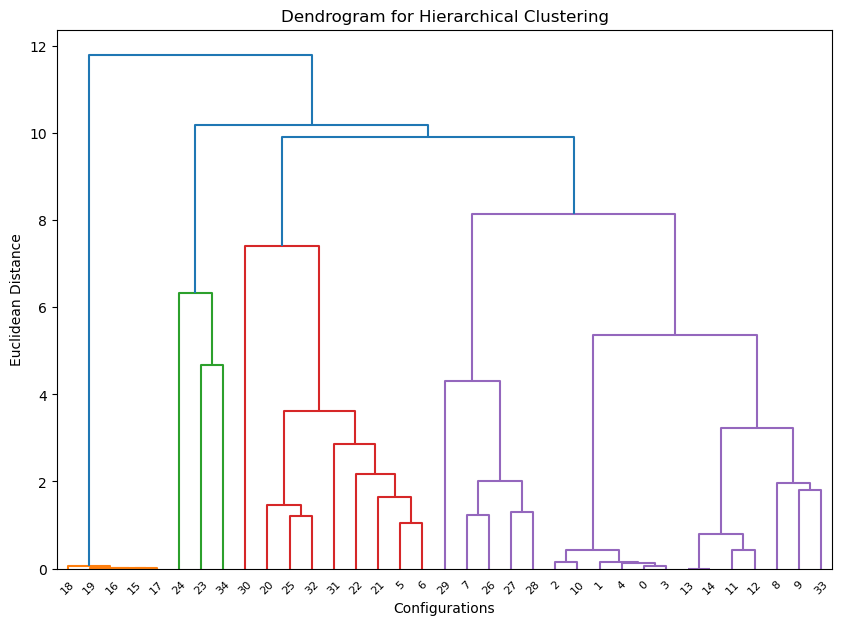

In [6]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Configurations')
plt.ylabel('Euclidean Distance')
plt.show()


Cut the Dendrogram selecting the max_distance

In [7]:
from scipy.cluster.hierarchy import fcluster

# Define the maximum distance threshold (e.g., 50)
max_distance = 8
clusters = fcluster(Z, max_distance, criterion='distance')

# Add the cluster labels to the DataFrame
aggregated_matrix['Cluster_Hierarchical'] = clusters


Summarize Cluster means

In [8]:
# Group by 'Cluster' and calculate the mean for each technology
cluster_summary = aggregated_matrix.groupby('Cluster_Hierarchical').mean()

# Show the resulting cluster summary
cluster_summary

techs,bioenergy,ccgt,coal,import_power,lost_load,nuclear,solar_pv,wind_offshore,wind_onshore
Cluster_Hierarchical,,,,,,,,,
1,3151.317811,3197.425777,0.032365,3703.556905,7.857804e-09,19533.242235,6460.703624,4133.587528,12421.596397
2,14515.809303,179.852061,4778.147536,7422.090528,8.615169e-02,1598.338294,6472.185202,4178.579181,6538.274927
3,21669.132363,4996.202216,2409.350200,1575.062550,1.789481e-03,2045.275665,6485.021547,4215.081295,8173.220524
4,12544.335075,11214.114157,263.431652,2840.996950,1.723859e-03,1713.130778,6460.825582,4155.337350,6831.952932
5,18590.138169,1457.045068,85.884828,4481.637032,4.473296e-04,1592.307525,6461.005438,4131.789534,9993.600438


Plot the average configiurations of each Cluster

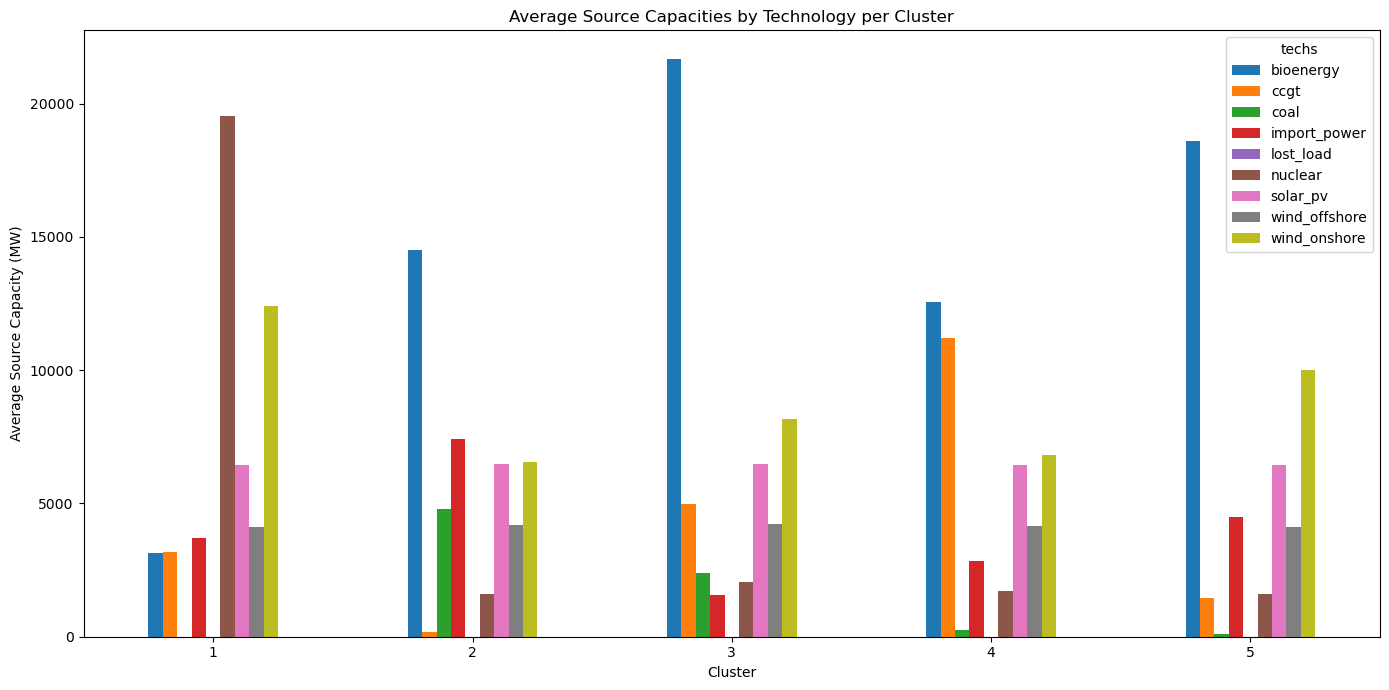

In [9]:
# Plot bar chart for each cluster
cluster_summary.plot(kind='bar', figsize=(14, 7))

plt.title('Average Source Capacities by Technology per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Source Capacity (MW)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Find and plot representative configurations for each Cluster

Cluster 5 - Shape of cluster_configs: (13, 9)
Cluster 3 - Shape of cluster_configs: (9, 9)
Cluster 4 - Shape of cluster_configs: (5, 9)
Cluster 1 - Shape of cluster_configs: (5, 9)
Cluster 2 - Shape of cluster_configs: (3, 9)
Representative configurations: ['spores\\maxhyd_spore_2', 'spores\\minbat_spore_2', 'spores\\minhyd_spore_4', 'spores\\maxnuc_spore_1', 'spores\\minbat_spore_4']


<Figure size 1400x700 with 0 Axes>

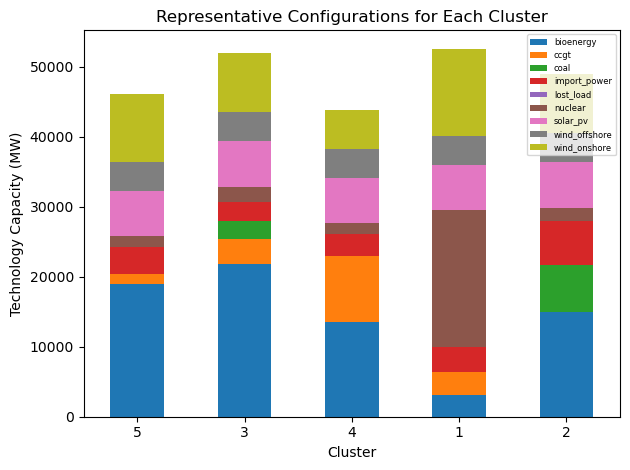

In [10]:
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
import numpy as np

# Assuming 'aggregated_matrix' is your DataFrame with the 'Cluster' and technology columns
# 1. Compute the centroids of each cluster (mean of each technology in each cluster)
cluster_centroids = aggregated_matrix.groupby('Cluster_Hierarchical').mean()

# 2. Find the configuration closest to the centroid for each cluster
representative_configs = []

for cluster in aggregated_matrix['Cluster_Hierarchical'].unique():
    # Get the configurations in the current cluster
    cluster_configs = aggregated_matrix[aggregated_matrix['Cluster_Hierarchical'] == cluster].drop(columns=['Cluster_Hierarchical'])

    # Print the shape of the data to verify it's correct
    print(f"Cluster {cluster} - Shape of cluster_configs: {cluster_configs.shape}")

    # Calculate the centroid for the current cluster
    centroid = cluster_centroids.loc[cluster]

    # Compute the Euclidean distances between each configuration and the centroid
    distances = cdist(cluster_configs, centroid.values.reshape(1, -1), metric='euclidean')

    # Get the index of the closest configuration (minimum distance)
    closest_index = np.argmin(distances)
    representative_config = cluster_configs.iloc[closest_index].name

    # Append the representative configuration's index
    representative_configs.append(representative_config)

# Print the representative configurations' indices
print(f"Representative configurations: {representative_configs}")

# 3. Retrieve the representative configurations from the 'aggregated_matrix'
df_representative_configs = aggregated_matrix.loc[representative_configs]

# 4. Plot the representative configurations (one bar plot per cluster)
plt.figure(figsize=(14, 7))
df_representative_configs.drop(columns=['Cluster_Hierarchical']).plot(kind='bar', stacked=True)

# Add titles and labels
plt.title('Representative Configurations for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Technology Capacity (MW)')
plt.xticks(range(len(df_representative_configs)), labels=df_representative_configs['Cluster_Hierarchical'], rotation=0)
plt.tight_layout()
plt.legend(loc='upper right', prop={'size': 6})
plt.show()

